<a href="https://colab.research.google.com/github/sage959/EmployeeSalaryPrediction/blob/main/employee_salary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas scikit-learn joblib streamlit matplotlib colabcode

In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

In [ ]:
# Upload dataset
df = pd.read_csv('adult.csv')
print("Original shape:", df.shape)
df.head()

Original shape: (48842, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [ ]:
#Show missing counts per column
print(df.isna().sum())

age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64


In [ ]:
# Replace “?” with unknown
df.replace('?', np.nan, inplace=True)

#Show missing counts per column
print(df.isna().sum())


age                   0
workclass          2799
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2809
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      857
income                0
dtype: int64


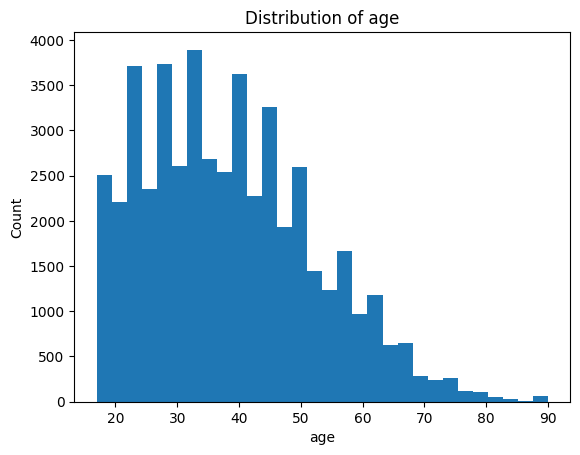

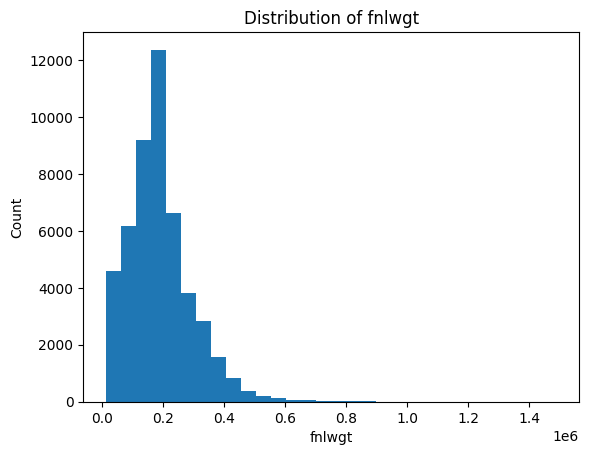

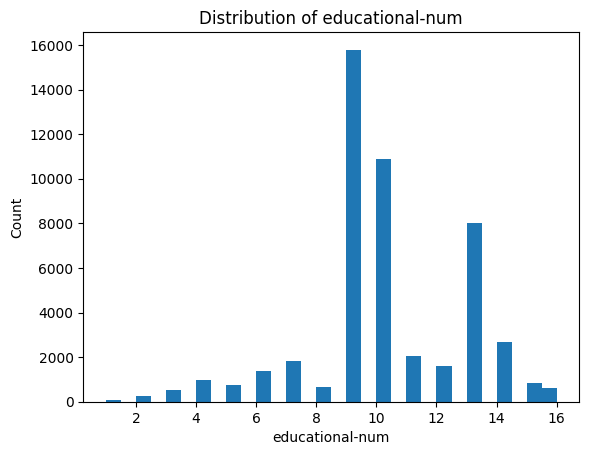

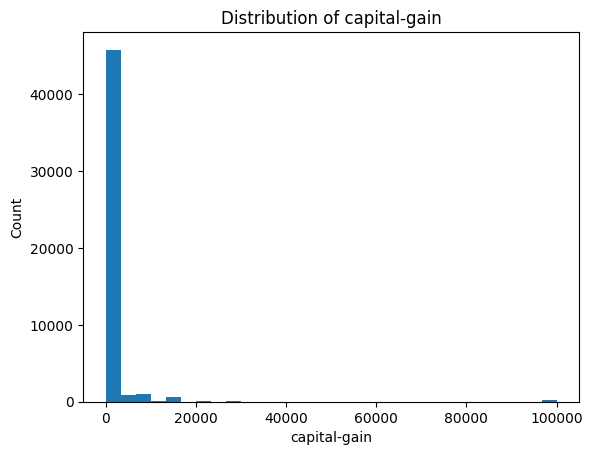

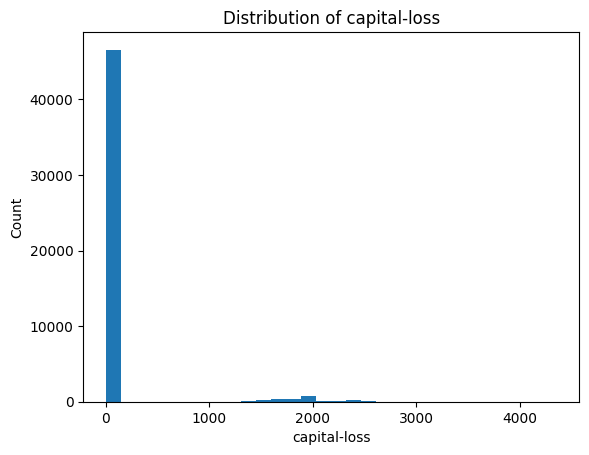

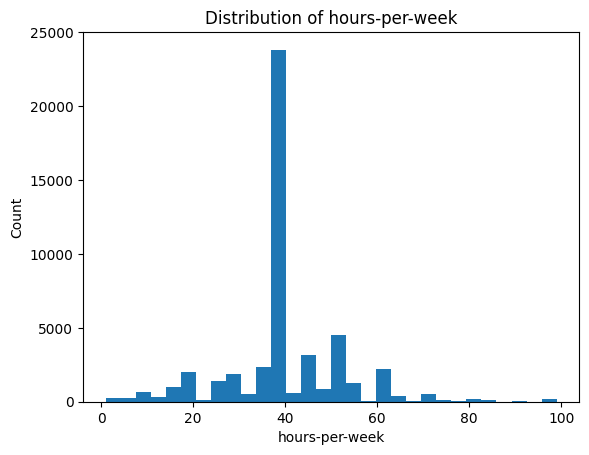

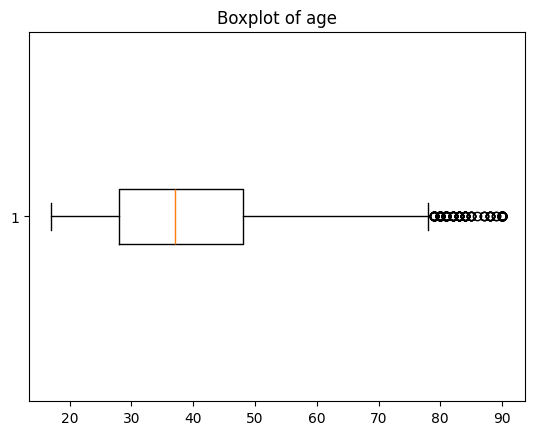

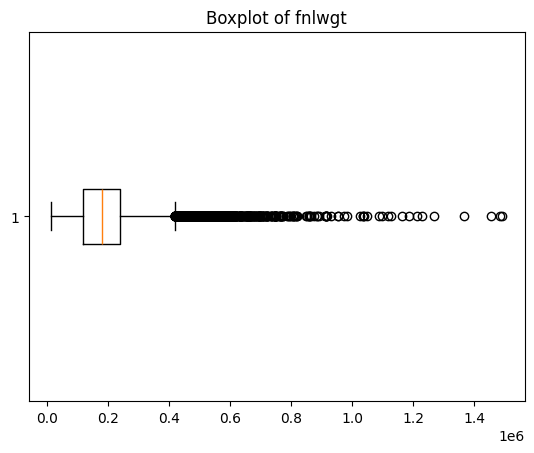

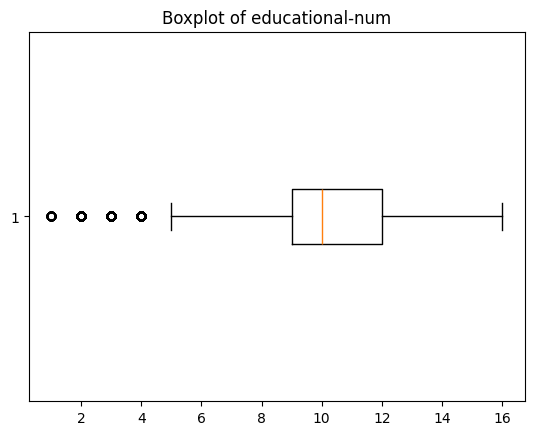

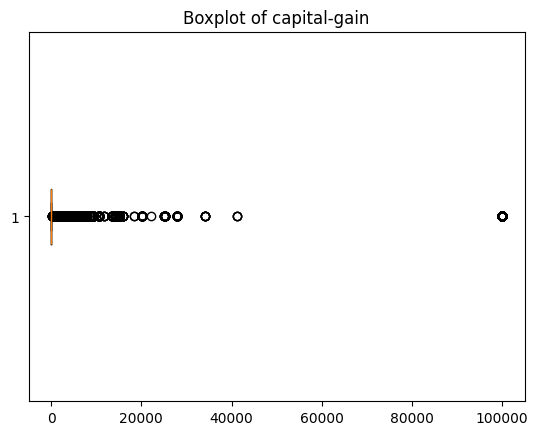

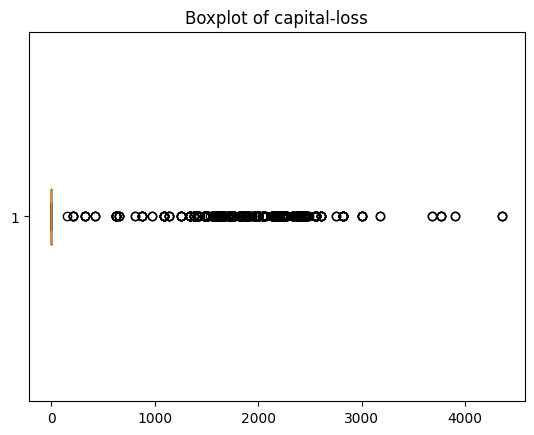

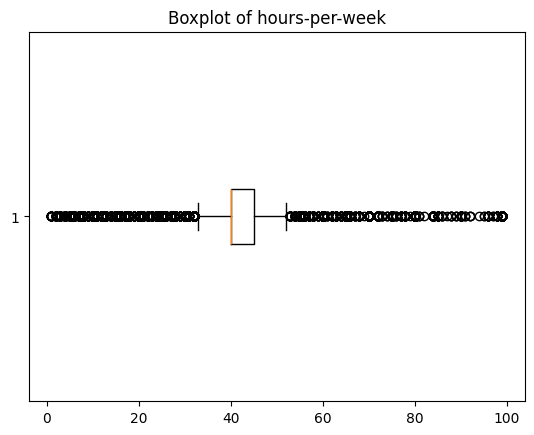

In [ ]:
# Numeric columns
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()

# Histograms
for col in num_cols:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

# Boxplots
for col in num_cols:
    plt.figure()
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f'Boxplot of {col}')
    plt.show()


In [ ]:
df_clean = df.copy()
for col in num_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

print("After outlier removal:", df_clean.shape)


After outlier removal: (28560, 15)


In [ ]:
# Separate features and target
X = df_clean.drop('income', axis=1)
y = df_clean['income']

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Identify types
num_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Numeric :scale
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())
])

# Categorical :one‑hot
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


In [ ]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=200),
    'KNN':                KNeighborsClassifier()
}

results = {}
for name, clf in models.items():
    pipe = Pipeline([
        ('preproc', preprocessor),
        ('clf',     clf)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"{name} accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))
    results[name] = (pipe, acc)


LogisticRegression accuracy: 0.8363
              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90      4508
        >50K       0.65      0.48      0.55      1204

    accuracy                           0.84      5712
   macro avg       0.76      0.71      0.73      5712
weighted avg       0.82      0.84      0.83      5712

KNN accuracy: 0.8167
              precision    recall  f1-score   support

       <=50K       0.87      0.90      0.89      4508
        >50K       0.57      0.51      0.54      1204

    accuracy                           0.82      5712
   macro avg       0.72      0.70      0.71      5712
weighted avg       0.81      0.82      0.81      5712



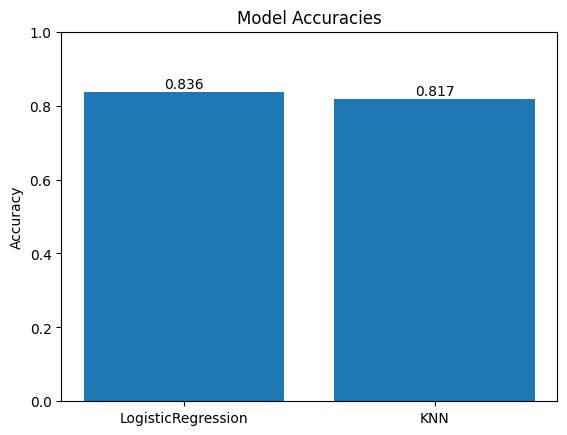

In [ ]:
names = list(results.keys())
accs  = [results[n][1] for n in names]

plt.figure()
plt.bar(names, accs)
plt.title('Model Accuracies')
plt.ylabel('Accuracy')
plt.ylim(0,1)
for i,(n,a) in enumerate(zip(names, accs)):
    plt.text(i, a+0.01, f"{a:.3f}", ha='center')
plt.show()


In [ ]:
best_name, (best_pipe, best_acc) = max(results.items(), key=lambda x: x[1][1])
print(f"Best model: {best_name} ({best_acc:.4f})")
joblib.dump(best_pipe, 'best_model_pipeline.joblib')
print("→ Pipeline saved as best_model_pipeline.joblib")


Best model: LogisticRegression (0.8363)
→ Pipeline saved as best_model_pipeline.joblib


In [ ]:
%%bash
cat > app.py << 'EOF'
import streamlit as st
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# Load pipeline
model = joblib.load('best_model_pipeline.joblib')

st.set_page_config(page_title='Employeee Income Predictor', layout='centered')
st.title('Employee Income Prediction')

# Sidebar: upload & preview
st.sidebar.header('Upload Dataset')
uploaded = st.sidebar.file_uploader('CSV file', type='csv')
if uploaded:
    data = pd.read_csv(uploaded)
    st.sidebar.dataframe(data.head())

# Main: EDA graphs on uploaded data
if uploaded:
    st.header('Uploaded Data Distributions')
    num_cols = data.select_dtypes(include=['int64','float64']).columns
    for col in num_cols:
        fig, ax = plt.subplots()
        ax.hist(data[col].dropna(), bins=30)
        ax.set_title(f'Distribution of {col}')
        st.pyplot(fig)

# Manual input for prediction
st.header('Predict Income Bracket')
with st.form('input_form'):
    inputs = {}
    for col in model.named_steps['preproc'].transformers_[0][2]:
        inputs[col] = st.number_input(col)
    for col in model.named_steps['preproc'].transformers_[1][2]:
        inputs[col] = st.text_input(col)
    submitted = st.form_submit_button('Predict')

if submitted:
    df_in = pd.DataFrame([inputs])
    pred = model.predict(df_in)[0]
    st.success(f'Predicted income: {pred}')

st.markdown('---')
st.write('Built by Siddharth Singh')
EOF


In [ ]:
!pip install pyngrok streamlit


In [ ]:
from pyngrok import ngrok

#close all active tunnels
ngrok.kill()

In [ ]:
from pyngrok import ngrok
import subprocess, time

# ── OPTIONAL ──
# If you have an ngrok authtoken, uncomment and set it:
ngrok.set_auth_token("2yzWyHGBk3LHulRmxVD7J1R0n2G_4rEtrvWg5rkDSW9uymwYW")

# 1) Start your Streamlit app in the background
subprocess.Popen([
    "streamlit", "run", "app.py",
    "--server.address=0.0.0.0",
    "--server.port=8501",
    "--server.headless=true"
])

# 2) Give Streamlit a few seconds to fire up
time.sleep(5)

# 3) Open an HTTP tunnel on port 8501
public_url = ngrok.connect(addr="8501", proto="http")
print("🔗 Your Streamlit app is live at:", public_url)


🔗 Your Streamlit app is live at: NgrokTunnel: "https://c4f29e699fec.ngrok-free.app" -> "http://localhost:8501"
